# Quick CNN Training - Ultra Lightweight + Augmentation
## Streamlined version for rapid iteration

This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.11.3


In [2]:
# CONFIG
df_sensor = pd.read_csv('./data/final_dataset.csv')
df_windows = pd.read_csv('./data/final_window_labels.csv') 

concept_columns = {'periodicity', 'temporal_stability', 'coordination', 'motion_intensity', 'vertical_dominance', 'static_posture'}
discrete_concepts = {'periodicity', 'temporal_stability', 'coordination', 'static_posture'}
continuous_concepts = {'motion_intensity', 'vertical_dominance'}

In [3]:


print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")
print(f"\nLabeled windows:")
print(df_windows.head())

print(f"\nAvailable concepts: {concept_columns}")
print(f"\nConcept distributions:")

for concept in concept_columns:
    if concept not in df_windows.columns:
        print(f"  {concept}: (missing from data)")
        continue

    if concept in discrete_concepts:
        print(f"\n  [Discrete] {concept}:")
        print(df_windows[concept].value_counts(dropna=False))
    elif concept in continuous_concepts:
        print(f"\n  [Continuous] {concept}:")
        print(df_windows[concept].describe())
    else:
        print(f"\n  [Unknown type] {concept}:")
        print(df_windows[concept].head())

Sensor data: 8802 readings
Manual labels: 150 windows

Labeled windows:
   window_idx  user activity  start_time  end_time  periodicity  \
0           0     3  Walking      957.75    960.75          1.0   
1           1     3  Walking       42.00     45.00          1.0   
2           2     3  Walking      871.50    874.50          0.5   
3           3     3  Walking       63.00     66.00          1.0   
4           4     3  Jogging      117.75    120.75          1.0   

   temporal_stability  coordination  motion_intensity  vertical_dominance  \
0                 0.5           0.5          0.316815            0.221105   
1                 0.5           0.5          0.302850            0.291116   
2                 0.5           0.5          0.303036            0.181147   
3                 0.5           0.5          0.313779            0.305797   
4                 0.5           0.5          0.408648            0.262989   

   static_posture  
0             0.0  
1             0.0  
2 

In [4]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 60
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 6 concepts.
    """
    X = []
    y_p = []  # periodicity
    y_t = []  # temporal_stability
    y_c = []  # coordination
    y_mi = [] # motion_intensity
    y_vd = [] # vertical_dominance
    y_sp = [] # static_posture
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            y_mi.append(window_row['motion_intensity'])
            y_vd.append(window_row['vertical_dominance'])
            y_sp.append(window_row['static_posture'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mi), np.array(y_vd), np.array(y_sp)

In [5]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mi, y_vd, y_sp, factor=10):
    """
    Create augmented versions of the dataset for 7 concepts.
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c, y_mi, y_vd, y_sp, y_mag: Labels for seven concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mi_aug = np.zeros(n_augmented)
    y_vd_aug = np.zeros(n_augmented)
    y_sp_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mi_aug[i] = y_mi[idx]
        y_vd_aug[i] = y_vd[idx]
        y_sp_aug[i] = y_sp[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mi_combined = np.concatenate([y_mi, y_mi_aug])
    y_vd_combined = np.concatenate([y_vd, y_vd_aug])
    y_sp_combined = np.concatenate([y_sp, y_sp_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mi_combined, y_vd_combined, y_sp_combined

In [6]:
# OPTIMIZED MODEL WITH BEST GRID SEARCH PARAMETERS FOR 7 CONCEPTS
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, n_classes_sp):
    """
    Optimized CNN using best parameters from grid search for 7 concepts:
    - conv_filters_1: 16, conv_filters_2: 16
    - dropout_rate: 0.4
    - learning_rate: 0.001 (will be set in compile)
    - batch_size: 32 (will be set in fit)
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Conv layer 1 (optimized: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Conv layer 2 (optimized: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dropout (optimized: 0.4)
    x = layers.Dropout(0.4)(x)
    
    # Discrete concepts
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    static_posture = layers.Dense(n_classes_sp, activation='softmax', name='static_posture')(x)
    
    # Continuous concepts
    motion_intensity = layers.Dense(1, activation='linear', name='motion_intensity')(x)
    vertical_dominance = layers.Dense(1, activation='linear', name='vertical_dominance')(x)
    
    model = models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination, motion_intensity, vertical_dominance, static_posture])
    
    return model

# Helper function to calculate AUROC for multi-output model
def calculate_auroc_multi_output(y_true_categorical, y_pred_proba, concept_name, num_classes):
    """
    Calculate AUROC for multi-output CNN concepts
    
    Args:
        y_true_categorical: True labels in categorical format
        y_pred_proba: Predicted probabilities from model
        concept_name: Name of the concept (for discrete concepts only)
        num_classes: Number of classes for this concept
    
    Returns:
        AUROC score
    """
    # Convert categorical to integer labels
    y_true = np.argmax(y_true_categorical, axis=1)
    
    # For binary classification (2 classes)
    if num_classes == 2:
        # Use the probability of the positive class
        y_scores = y_pred_proba[:, 1]
        return roc_auc_score(y_true, y_scores)
    
    # For multi-class (3+ classes)
    else:
        # Binarize the labels for multi-class AUROC calculation
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        if y_true_bin.shape[1] == 1:
            # Binary case
            return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
        else:
            # Multi-class case
            return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')


In [7]:
# Extract windows
print("Extracting windows...")
X, y_p, y_t, y_c, y_mi, y_vd, y_sp = extract_windows_robust(df_sensor, df_windows)

print(f"Extracted {len(X)} windows")
print(f"Window shape: {X.shape}")
print(f"Label distributions:")
print(f"  Periodicity: {np.bincount(y_p.astype(int))}")
print(f"  Temporal Stability: {np.bincount(y_t.astype(int))}")
print(f"  Coordination: {np.bincount(y_c.astype(int))}")
print(f"  Motion Intensity: {np.bincount(y_mi.astype(int))}")
print(f"  Vertical Dominance: {np.bincount(y_vd.astype(int))}")
print(f"  Static Posture: {np.bincount(y_sp.astype(int))}")

Extracting windows...
Extracted 150 windows
Window shape: (150, 60, 3)
Label distributions:
  Periodicity: [125  25]
  Temporal Stability: [99 51]
  Coordination: [80 70]
  Motion Intensity: [150]
  Vertical Dominance: [150]
  Static Posture: [150]


In [8]:
# Random shuffle split (75% train, 25% test)
print("Splitting data...")
X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, y_mi_train, y_mi_test, y_vd_train, y_vd_test, y_sp_train, y_sp_test = train_test_split(
    X, y_p, y_t, y_c, y_mi, y_vd, y_sp, test_size=0.25, random_state=42, stratify=None
)

print(f"Train: {len(X_train)} windows")
print(f"Test: {len(X_test)} windows")

Splitting data...
Train: 112 windows
Test: 38 windows


In [9]:
# Apply augmentation
print("Augmenting training data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mi_train_aug, y_vd_train_aug, y_sp_train_aug = augment_dataset(
    X_train, y_p_train, y_t_train, y_c_train, y_mi_train, y_vd_train, y_sp_train, factor=10
)

print(f"Original train: {len(X_train)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")
print(f"Augmentation factor: {len(X_train_aug) / len(X_train):.1f}x")

Augmenting training data...
Original train: 112 windows
Augmented train: 1232 windows
Augmentation factor: 11.0x


In [10]:
# Convert labels to categorical
# Discrete
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)
y_sp_train_cat = to_categorical(y_sp_train_aug * 2, num_classes=2)

# Continous
y_mi_train_cat = y_mi_train_aug.astype(np.float32).reshape(-1, 1)
y_vd_train_cat = y_vd_train_aug.astype(np.float32).reshape(-1, 1)

# Discrete
y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)
y_sp_test_cat = to_categorical(y_sp_test * 2, num_classes=2)

# Continous
y_mi_test_cat = y_mi_test.astype(np.float32).reshape(-1, 1)
y_vd_test_cat = y_vd_test.astype(np.float32).reshape(-1, 1)

print("Labels converted to categorical format")

Labels converted to categorical format


In [11]:
# Build and compile model
print("Building model...")
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3, n_classes_sp=2
)

# Compile with appropriate loss weights
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'periodicity': 'categorical_crossentropy',
            'temporal_stability': 'categorical_crossentropy',
            'coordination': 'categorical_crossentropy',
            'static_posture': 'categorical_crossentropy',
            'motion_intensity': 'mse',
            'vertical_dominance': 'mse'
        },
        loss_weights={
            'periodicity': 1.0,
            'temporal_stability': 1.0,
            'coordination': 1.0,
            'static_posture': 1.0,
            'motion_intensity': 1.0,
            'vertical_dominance': 1.0
        },
        metrics={
            'periodicity': ['accuracy'],
            'temporal_stability': ['accuracy'],
            'coordination': ['accuracy'],
            'static_posture': ['accuracy'],
            'motion_intensity': ['mse'],
            'vertical_dominance': ['mse']
        }
    )
    

print(f"Model parameters: {model.count_params():,}")
model.summary()

Building model...
Model parameters: 1,293


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 16)    │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 30, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 16)    │        784 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 16)    │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodicity (Dense) │ (None, 3)         │         51 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_stability  │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coordination        │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motion_intensity    │ (None, 1)         │         17 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vertical_dominance  │ (None, 1)         │         17 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_posture      │ (None, 2)         │         34 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,293 (5.05 KB)

 Trainable params: 1,229 (4.80 KB)

 Non-trainable params: 64 (256.00 B)

In [12]:
# Train model
print("Training model...")
history = model.fit(
    X_train_aug,
    [y_p_train_cat, y_t_train_cat, y_c_train_cat, y_mi_train_cat, y_vd_train_cat, y_sp_train_cat],
    validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat, y_sp_test_cat]),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

print("Training completed!")

Training model...
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - coordination_accuracy: 0.4716 - coordination_loss: 1.0671 - loss: 5.1246 - motion_intensity_loss: 0.6712 - motion_intensity_mse: 0.6763 - periodicity_accuracy: 0.3312 - periodicity_loss: 1.1687 - static_posture_accuracy: 0.5154 - static_posture_loss: 0.7784 - temporal_stability_accuracy: 0.5049 - temporal_stability_loss: 0.9928 - vertical_dominance_loss: 0.4315 - vertical_dominance_mse: 0.4348 - val_coordination_accuracy: 0.3947 - val_coordination_loss: 1.0293 - val_loss: 4.7747 - val_motion_intensity_loss: 0.3489 - val_motion_intensity_mse: 0.3482 - val_periodicity_accuracy: 0.6579 - val_periodicity_loss: 0.9409 - val_static_posture_accuracy: 0.0526 - val_static_posture_loss: 1.0803 - val_temporal_stability_accuracy: 0.6316 - val_temporal_stability_loss: 0.6922 - val_vertical_dominance_loss: 0.4749 - val_vertical_dominance_mse: 0.4709 - learning_rate: 0.0010
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - coo

In [17]:
y_test_map = {
    'periodicity': y_p_test_cat,
    'temporal_stability': y_t_test_cat,
    'coordination': y_c_test_cat,
    'motion_intensity': y_mi_test_cat,
    'vertical_dominance': y_vd_test_cat,
    'static_posture': y_sp_test_cat
}

# Evaluate model
print("Evaluating model...")
results = model.evaluate(X_test, list(y_test_map.values()), verbose=0)


predictions = model.predict(X_test, verbose=0)
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
motion_intensity_pred = np.argmax(predictions[3], axis=1)
vertical_dominance_pred = np.argmax(predictions[4], axis=1)
static_posture_pred = np.argmax(predictions[5], axis=1)

periodicity_acc = accuracy_score(np.argmax(y_p_test_cat, axis=1), periodicity_pred)
temporal_stability_acc = accuracy_score(np.argmax(y_t_test_cat, axis=1), temporal_stability_pred)
coordination_acc = accuracy_score(np.argmax(y_c_test_cat, axis=1), coordination_pred)
motion_intensity_acc = accuracy_score(np.argmax(y_mi_test_cat, axis=1), motion_intensity_pred)
vertical_dominance_acc = accuracy_score(np.argmax(y_vd_test_cat, axis=1), vertical_dominance_pred)
static_posture_acc = accuracy_score(np.argmax(y_sp_test_cat, axis=1), static_posture_pred)

# Calculate AUROC only for discrete classification concepts
periodicity_auroc = calculate_auroc_multi_output(y_p_test_cat, predictions[0], 'periodicity', 3)
temporal_stability_auroc = calculate_auroc_multi_output(y_t_test_cat, predictions[1], 'temporal_stability', 3)
coordination_auroc = calculate_auroc_multi_output(y_c_test_cat, predictions[2], 'coordination', 3)

# Handle Static Posture separately to avoid NaN
print(f"Debug - Static Posture labels: {np.argmax(y_sp_test_cat, axis=1)}")
print(f"Debug - Static Posture unique labels: {np.unique(np.argmax(y_sp_test_cat, axis=1))}")
print(f"Debug - Static Posture label counts: {np.bincount(np.argmax(y_sp_test_cat, axis=1))}")

try:
    static_posture_auroc = calculate_auroc_multi_output(y_sp_test_cat, predictions[5], 'static_posture', 2)
    if np.isnan(static_posture_auroc):
        print("Warning: Static Posture AUROC is NaN, likely due to class imbalance")
        static_posture_auroc = 0.5  # Set to random performance
except Exception as e:
    print(f"Warning: Static Posture AUROC calculation failed: {e}")
    static_posture_auroc = 0.5  # Set to random performance

# For continuous concepts, we'll use R² score instead of AUROC
from sklearn.metrics import r2_score
motion_intensity_r2 = r2_score(y_mi_test_cat.flatten(), predictions[3].flatten())
vertical_dominance_r2 = r2_score(y_vd_test_cat.flatten(), predictions[4].flatten())

overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + motion_intensity_acc + vertical_dominance_acc + static_posture_acc) / len(concept_columns)

# Calculate overall AUROC, excluding any NaN values
auroc_scores = [periodicity_auroc, temporal_stability_auroc, coordination_auroc, static_posture_auroc]
valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
overall_auroc = np.mean(valid_auroc_scores) if valid_auroc_scores else 0.5

print(f"\n=== RESULTS ===")
print(f"\n--- Classification Concepts (Discrete) ---")
print(f"Periodicity - Accuracy: {periodicity_acc:.4f}, AUROC: {periodicity_auroc:.4f}")
print(f"Temporal Stability - Accuracy: {temporal_stability_acc:.4f}, AUROC: {temporal_stability_auroc:.4f}")
print(f"Coordination - Accuracy: {coordination_acc:.4f}, AUROC: {coordination_auroc:.4f}")
print(f"Static Posture - Accuracy: {static_posture_acc:.4f}, AUROC: {static_posture_auroc:.4f}")

print(f"\n--- Regression Concepts (Continuous) ---")
print(f"Motion Intensity - Accuracy: {motion_intensity_acc:.4f}, R²: {motion_intensity_r2:.4f}")
print(f"Vertical Dominance - Accuracy: {vertical_dominance_acc:.4f}, R²: {vertical_dominance_r2:.4f}")

print(f"\n--- Overall Performance ---")
print(f"Overall Average Accuracy: {overall_acc*100:.1f}%")
print(f"Overall Average AUROC (classification concepts): {overall_auroc:.4f}")

Evaluating model...
Debug - Static Posture labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
Debug - Static Posture unique labels: [0]
Debug - Static Posture label counts: [38]

=== RESULTS ===

--- Classification Concepts (Discrete) ---
Periodicity - Accuracy: 0.7105, AUROC: 0.8952
Temporal Stability - Accuracy: 0.7368, AUROC: 0.8449
Coordination - Accuracy: 0.6842, AUROC: 0.8315
Static Posture - Accuracy: 1.0000, AUROC: 0.5000

--- Regression Concepts (Continuous) ---
Motion Intensity - Accuracy: 1.0000, R²: 0.1455
Vertical Dominance - Accuracy: 1.0000, R²: 0.2567

--- Overall Performance ---
Overall Average Accuracy: 85.5%
Overall Average AUROC (classification concepts): 0.7679


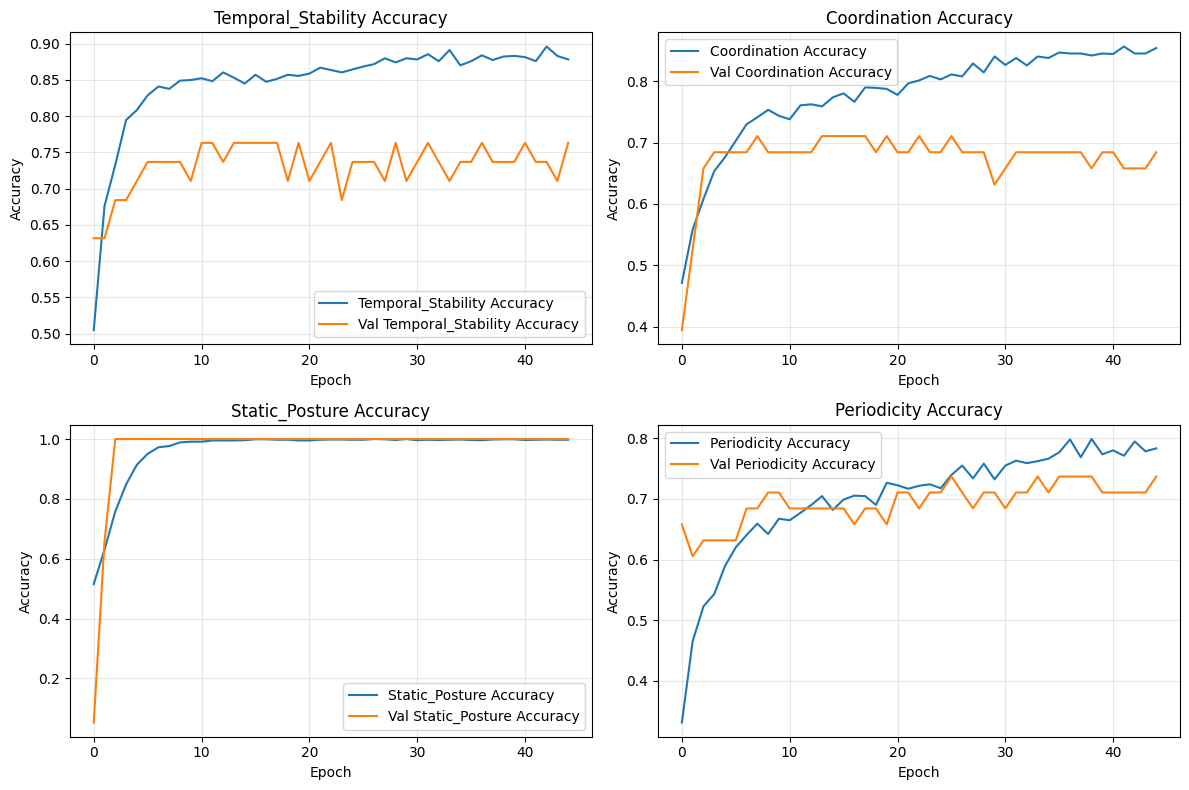

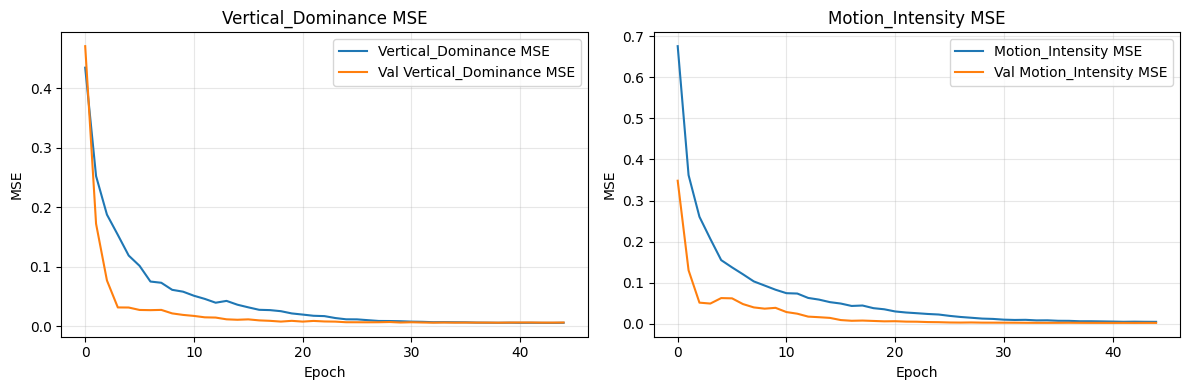

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, concept in enumerate(discrete_concepts):
    row, col = i // 2, i % 2
    axes[row, col].plot(history.history[f'{concept}_accuracy'], label=f'{concept.title()} Accuracy')
    axes[row, col].plot(history.history[f'val_{concept}_accuracy'], label=f'Val {concept.title()} Accuracy')
    axes[row, col].set_title(f'{concept.title()} Accuracy')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, concept in enumerate(continuous_concepts):
    axes[i].plot(history.history[f'{concept}_mse'], label=f'{concept.title()} MSE')
    axes[i].plot(history.history[f'val_{concept}_mse'], label=f'Val {concept.title()} MSE')
    axes[i].set_title(f'{concept.title()} MSE')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('MSE')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
model.save("sensor_data_to_concept_model.keras")
print("Model saved to sensor_data_to_concept_model.keras")


Model saved to sensor_data_to_concept_model.keras
